In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [3]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 22

In [4]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [54]:
def get_euclid_dis_tips_and_palm_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
    hand_name = ['left', 'right']
    
    fingertip_pos = np.zeros([2, 5, 3])
    
    hand_palm_pos = np.zeros([2, 3])
    hand_palm_rpy = np.zeros([2, 3])
    dist_fingertip_palm = np.zeros([10])
    
    feature = np.zeros([2*3 + 2*3 + 10])
    
    for hand_idx, hand in enumerate(hand_name):
        if not hand in frame['hands']:
            continue
        hand_palm_pos[hand_idx] = np.array(frame['hands'][hand]['hand_palm_position'])
        hand_palm_rpy[hand_idx] = np.array([ frame['hands'][hand]['roll'],
                                                    frame['hands'][hand]['pitch'],
                                                    frame['hands'][hand]['yaw']])
        for finger_idx, finger in enumerate(finger_name):
            fingertip_pos[hand_idx, finger_idx] = (
                np.array(frame['hands'][hand]['fingers'][finger]['bones']['distal']['next_joint'])
            )
            
            dist_fingertip_palm[hand_idx*5 + finger_idx] = np.linalg.norm(
                fingertip_pos[hand_idx, finger_idx] - hand_palm_pos[hand_idx]
            )
        
    feature[0:6] = hand_palm_pos.reshape(6)
    feature[6:12] = hand_palm_rpy.reshape(6)
    feature[12:22] = dist_fingertip_palm.T
    
#     print(feature[12+5:12+6])
#     print(frame['hands']['right']['fingers']['thumb']['bones']['distal']['next_joint'])
#     print(hand_palm_pos[1])
    return feature
    

In [18]:
def get_timesteps(json_data, pick_frame_every_no): 
    timesteps = np.zeros([0, dimensions])
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']:
            continue
#         feature = get_feature(frame)
        feature = get_euclid_dis_tips_and_palm_feature(frame)
        timesteps = np.vstack((timesteps, feature))
    return timesteps

In [19]:
def get_fake_speedup_timesteps_1(percent, json_data, pick_frame_every_no):
    return get_timesteps(json_data, pick_frame_every_no*(100+percent)//100)

In [20]:
def get_fake_speedup_timesteps_2(percent, old_timesteps, old_pick_frame_every_no):
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_no = old_pick_frame_every_no*(100+percent)//100
    timesteps_length = (old_timesteps.shape[0] * old_pick_frame_every_no) // pick_frame_every_no
    
    for new_index in range(1, timesteps_length):
        start_old_index = (new_index * pick_frame_every_no) // old_pick_frame_every_no
        x1 = old_pick_frame_every_no*start_old_index
        x2 = old_pick_frame_every_no*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        _x = (new_index * pick_frame_every_no)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps
        
    

In [21]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [22]:
speedup = 10
pick_frame_every_no = int((max_frame * (speedup < 0 and (100-speedup)/100 or 1)) // 50 + 1)

In [55]:
x = np.zeros([0, timesteps, dimensions])
y = np.zeros([0])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)
        
        _timesteps = get_fake_speedup_timesteps_2(+10, _timesteps, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)

In [56]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [57]:
x_train = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 // 3])
x_test = np.zeros([data_length // 3, timesteps, dimensions])
y_test = np.zeros([data_length // 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx // 3] = x_norm[idx]
        y_test[idx // 3] = y[idx]
    else:
        x_train[idx - idx // 3] = x_norm[idx]
        y_train[idx - idx // 3] = y[idx]

In [58]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 // 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [59]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [60]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=1000, batch_size=8, shuffle=True)

Train on 684 samples, validate on 342 samples
Epoch 1/1000
684/684 [==============================] - 3s 4ms/step - loss: 2.9750 - acc: 0.0351 - val_loss: 2.9466 - val_acc: 0.0526
Epoch 2/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.9531 - acc: 0.0453 - val_loss: 2.9200 - val_acc: 0.0848
Epoch 3/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.9176 - acc: 0.0599 - val_loss: 2.8508 - val_acc: 0.0848
Epoch 4/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.8105 - acc: 0.0643 - val_loss: 2.6755 - val_acc: 0.1257
Epoch 5/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.7626 - acc: 0.0746 - val_loss: 2.5874 - val_acc: 0.1082
Epoch 6/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.7100 - acc: 0.0906 - val_loss: 2.5618 - val_acc: 0.1053
Epoch 7/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.6849 - acc: 0.0906 - val_loss: 2.5156 - val_acc: 0.1228
Epoch 8/1000
684

684/684 [==============================] - 2s 3ms/step - loss: 2.2411 - acc: 0.2325 - val_loss: 2.0598 - val_acc: 0.2836
Epoch 62/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.2439 - acc: 0.1944 - val_loss: 2.0222 - val_acc: 0.2865
Epoch 63/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.2944 - acc: 0.2047 - val_loss: 2.0304 - val_acc: 0.2719
Epoch 64/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.3304 - acc: 0.1915 - val_loss: 2.0232 - val_acc: 0.3041
Epoch 65/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.2597 - acc: 0.2368 - val_loss: 2.0175 - val_acc: 0.3216
Epoch 66/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.2409 - acc: 0.2105 - val_loss: 2.0229 - val_acc: 0.2719
Epoch 67/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.2313 - acc: 0.2091 - val_loss: 1.9847 - val_acc: 0.3187
Epoch 68/1000
684/684 [==============================] - 2s 3ms/step 

684/684 [==============================] - 2s 3ms/step - loss: 2.0865 - acc: 0.2515 - val_loss: 1.7763 - val_acc: 0.3684
Epoch 122/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.1148 - acc: 0.2719 - val_loss: 1.8248 - val_acc: 0.3743
Epoch 123/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.1270 - acc: 0.2661 - val_loss: 1.7775 - val_acc: 0.3684
Epoch 124/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.1316 - acc: 0.2734 - val_loss: 1.7921 - val_acc: 0.3889
Epoch 125/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.1170 - acc: 0.2383 - val_loss: 1.7403 - val_acc: 0.4152
Epoch 126/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.0978 - acc: 0.2632 - val_loss: 1.7420 - val_acc: 0.3918
Epoch 127/1000
684/684 [==============================] - 2s 3ms/step - loss: 2.1284 - acc: 0.2500 - val_loss: 1.7135 - val_acc: 0.3830
Epoch 128/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 1.9045 - acc: 0.3246 - val_loss: 1.5138 - val_acc: 0.4795
Epoch 182/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.9031 - acc: 0.3143 - val_loss: 1.4956 - val_acc: 0.4883
Epoch 183/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.8719 - acc: 0.3465 - val_loss: 1.4564 - val_acc: 0.4825
Epoch 184/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.9268 - acc: 0.2953 - val_loss: 1.4866 - val_acc: 0.4591
Epoch 185/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.8232 - acc: 0.3406 - val_loss: 1.4735 - val_acc: 0.4912
Epoch 186/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.8985 - acc: 0.3289 - val_loss: 1.5029 - val_acc: 0.4561
Epoch 187/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.8408 - acc: 0.3538 - val_loss: 1.4757 - val_acc: 0.4766
Epoch 188/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 1.8191 - acc: 0.3348 - val_loss: 1.3896 - val_acc: 0.5292
Epoch 242/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7909 - acc: 0.3567 - val_loss: 1.3901 - val_acc: 0.5409
Epoch 243/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7656 - acc: 0.3743 - val_loss: 1.3807 - val_acc: 0.5175
Epoch 244/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7897 - acc: 0.3406 - val_loss: 1.3725 - val_acc: 0.4971
Epoch 245/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7916 - acc: 0.3494 - val_loss: 1.3877 - val_acc: 0.4971
Epoch 246/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7235 - acc: 0.3991 - val_loss: 1.3755 - val_acc: 0.5058
Epoch 247/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7365 - acc: 0.3553 - val_loss: 1.3593 - val_acc: 0.5117
Epoch 248/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 1.7473 - acc: 0.3684 - val_loss: 1.3890 - val_acc: 0.5058
Epoch 302/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7836 - acc: 0.3509 - val_loss: 1.4185 - val_acc: 0.4883
Epoch 303/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7255 - acc: 0.3509 - val_loss: 1.3463 - val_acc: 0.5088
Epoch 304/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7059 - acc: 0.3743 - val_loss: 1.3572 - val_acc: 0.4971
Epoch 305/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7780 - acc: 0.3567 - val_loss: 1.3650 - val_acc: 0.5058
Epoch 306/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7762 - acc: 0.3626 - val_loss: 1.3527 - val_acc: 0.4912
Epoch 307/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7151 - acc: 0.3421 - val_loss: 1.3484 - val_acc: 0.4971
Epoch 308/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 1.8213 - acc: 0.3787 - val_loss: 1.4214 - val_acc: 0.4678
Epoch 362/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7903 - acc: 0.3611 - val_loss: 1.4035 - val_acc: 0.4708
Epoch 363/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7021 - acc: 0.4020 - val_loss: 1.3946 - val_acc: 0.4825
Epoch 364/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7418 - acc: 0.3713 - val_loss: 1.3779 - val_acc: 0.4678
Epoch 365/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7092 - acc: 0.3670 - val_loss: 1.3639 - val_acc: 0.4737
Epoch 366/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7621 - acc: 0.3626 - val_loss: 1.3487 - val_acc: 0.4795
Epoch 367/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7190 - acc: 0.4108 - val_loss: 1.3626 - val_acc: 0.4737
Epoch 368/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 1.7622 - acc: 0.3713 - val_loss: 1.3698 - val_acc: 0.5205
Epoch 422/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7355 - acc: 0.3947 - val_loss: 1.3585 - val_acc: 0.5175
Epoch 423/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7193 - acc: 0.3728 - val_loss: 1.3607 - val_acc: 0.5088
Epoch 424/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7551 - acc: 0.3684 - val_loss: 1.3754 - val_acc: 0.5322
Epoch 425/1000
684/684 [==============================] - ETA: 0s - loss: 1.7294 - acc: 0.373 - 2s 3ms/step - loss: 1.7309 - acc: 0.3728 - val_loss: 1.3437 - val_acc: 0.5175
Epoch 426/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6973 - acc: 0.3918 - val_loss: 1.3601 - val_acc: 0.5205
Epoch 427/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7378 - acc: 0.3626 - val_loss: 1.3375 - val_acc: 0.5029
Epoch 428/1000
684/684 [=

684/684 [==============================] - 2s 3ms/step - loss: 1.7275 - acc: 0.3918 - val_loss: 1.3158 - val_acc: 0.5468
Epoch 482/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6991 - acc: 0.3933 - val_loss: 1.2990 - val_acc: 0.5497
Epoch 483/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6729 - acc: 0.4079 - val_loss: 1.3086 - val_acc: 0.5409
Epoch 484/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7117 - acc: 0.3933 - val_loss: 1.3284 - val_acc: 0.5468
Epoch 485/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6913 - acc: 0.3845 - val_loss: 1.3276 - val_acc: 0.5439
Epoch 486/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6739 - acc: 0.3889 - val_loss: 1.3533 - val_acc: 0.5351
Epoch 487/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6956 - acc: 0.3962 - val_loss: 1.3223 - val_acc: 0.5292
Epoch 488/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 1.6979 - acc: 0.3962 - val_loss: 1.3172 - val_acc: 0.5322
Epoch 542/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6504 - acc: 0.4035 - val_loss: 1.3104 - val_acc: 0.5322
Epoch 543/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7450 - acc: 0.3757 - val_loss: 1.3235 - val_acc: 0.5263
Epoch 544/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6841 - acc: 0.3684 - val_loss: 1.3101 - val_acc: 0.5439
Epoch 545/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6740 - acc: 0.4108 - val_loss: 1.2970 - val_acc: 0.5380
Epoch 546/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6889 - acc: 0.3918 - val_loss: 1.2967 - val_acc: 0.5439
Epoch 547/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6596 - acc: 0.4006 - val_loss: 1.3145 - val_acc: 0.5351
Epoch 548/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 2s 3ms/step - loss: 1.6607 - acc: 0.4313 - val_loss: 1.3051 - val_acc: 0.5351
Epoch 602/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6771 - acc: 0.4035 - val_loss: 1.3263 - val_acc: 0.5322
Epoch 603/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7119 - acc: 0.3699 - val_loss: 1.3203 - val_acc: 0.5205
Epoch 604/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7217 - acc: 0.3787 - val_loss: 1.3101 - val_acc: 0.5292
Epoch 605/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6829 - acc: 0.3991 - val_loss: 1.3066 - val_acc: 0.5380
Epoch 606/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6742 - acc: 0.3640 - val_loss: 1.3167 - val_acc: 0.5292
Epoch 607/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.7130 - acc: 0.4123 - val_loss: 1.3287 - val_acc: 0.5380
Epoch 608/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 3s 4ms/step - loss: 1.7219 - acc: 0.3889 - val_loss: 1.3031 - val_acc: 0.5146
Epoch 662/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6960 - acc: 0.3860 - val_loss: 1.3079 - val_acc: 0.5292
Epoch 663/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6373 - acc: 0.4035 - val_loss: 1.2930 - val_acc: 0.5292
Epoch 664/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6181 - acc: 0.4094 - val_loss: 1.2975 - val_acc: 0.5205
Epoch 665/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6735 - acc: 0.3860 - val_loss: 1.2793 - val_acc: 0.5234
Epoch 666/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6954 - acc: 0.3933 - val_loss: 1.2839 - val_acc: 0.5380
Epoch 667/1000
684/684 [==============================] - 2s 4ms/step - loss: 1.6896 - acc: 0.4123 - val_loss: 1.2883 - val_acc: 0.5351
Epoch 668/1000
684/684 [==============================] - 2s 3m

684/684 [==============================] - 3s 4ms/step - loss: 1.6262 - acc: 0.3977 - val_loss: 1.2884 - val_acc: 0.5409
Epoch 722/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.5973 - acc: 0.4137 - val_loss: 1.2921 - val_acc: 0.5526
Epoch 723/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7340 - acc: 0.3772 - val_loss: 1.3039 - val_acc: 0.5351
Epoch 724/1000
684/684 [==============================] - 2s 3ms/step - loss: 1.6940 - acc: 0.3816 - val_loss: 1.3088 - val_acc: 0.5292
Epoch 725/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6834 - acc: 0.3699 - val_loss: 1.2937 - val_acc: 0.5292
Epoch 726/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6265 - acc: 0.4020 - val_loss: 1.2828 - val_acc: 0.5409
Epoch 727/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6147 - acc: 0.3918 - val_loss: 1.2791 - val_acc: 0.5263
Epoch 728/1000
684/684 [==============================] - 3s 4m

684/684 [==============================] - 3s 5ms/step - loss: 1.6832 - acc: 0.3947 - val_loss: 1.2855 - val_acc: 0.5351
Epoch 782/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.6500 - acc: 0.3889 - val_loss: 1.2806 - val_acc: 0.5439
Epoch 783/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.7172 - acc: 0.3962 - val_loss: 1.2714 - val_acc: 0.5468 1.7196 - acc: 0.39 - ETA: 0s - loss: 1.6945 - acc: 0.40
Epoch 784/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.7113 - acc: 0.3728 - val_loss: 1.2763 - val_acc: 0.5380
Epoch 785/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.6410 - acc: 0.4094 - val_loss: 1.2710 - val_acc: 0.5468
Epoch 786/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.6503 - acc: 0.4020 - val_loss: 1.2703 - val_acc: 0.5439
Epoch 787/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.6936 - acc: 0.3874 - val_loss: 1.2844 - val_acc: 0.5292
Epoch 7

Epoch 841/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6719 - acc: 0.3860 - val_loss: 1.3071 - val_acc: 0.5292
Epoch 842/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6735 - acc: 0.3816 - val_loss: 1.3034 - val_acc: 0.5175
Epoch 843/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7298 - acc: 0.4342 - val_loss: 1.3090 - val_acc: 0.5263
Epoch 844/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7218 - acc: 0.3626 - val_loss: 1.3031 - val_acc: 0.5292
Epoch 845/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7147 - acc: 0.4152 - val_loss: 1.3006 - val_acc: 0.5292
Epoch 846/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7395 - acc: 0.3874 - val_loss: 1.2954 - val_acc: 0.5380
Epoch 847/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7008 - acc: 0.4313 - val_loss: 1.2982 - val_acc: 0.5351
Epoch 848/1000
684/684 [========================

684/684 [==============================] - 3s 5ms/step - loss: 1.7120 - acc: 0.4035 - val_loss: 1.3084 - val_acc: 0.5292
Epoch 902/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.6833 - acc: 0.4123 - val_loss: 1.3112 - val_acc: 0.5175
Epoch 903/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7179 - acc: 0.3860 - val_loss: 1.3052 - val_acc: 0.5205
Epoch 904/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.6529 - acc: 0.4020 - val_loss: 1.3041 - val_acc: 0.5439
Epoch 905/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6421 - acc: 0.4079 - val_loss: 1.3049 - val_acc: 0.5292
Epoch 906/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7026 - acc: 0.4064 - val_loss: 1.3070 - val_acc: 0.5322
Epoch 907/1000
684/684 [==============================] - 3s 5ms/step - loss: 1.7428 - acc: 0.3845 - val_loss: 1.3110 - val_acc: 0.5205
Epoch 908/1000
684/684 [==============================] - 3s 5m

684/684 [==============================] - 3s 4ms/step - loss: 1.6914 - acc: 0.4137 - val_loss: 1.2997 - val_acc: 0.5263
Epoch 962/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7162 - acc: 0.3918 - val_loss: 1.2919 - val_acc: 0.5263
Epoch 963/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6733 - acc: 0.3874 - val_loss: 1.2982 - val_acc: 0.5146
Epoch 964/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6487 - acc: 0.4269 - val_loss: 1.2885 - val_acc: 0.5205
Epoch 965/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.6369 - acc: 0.3947 - val_loss: 1.2898 - val_acc: 0.5175
Epoch 966/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7502 - acc: 0.3743 - val_loss: 1.2937 - val_acc: 0.5409
Epoch 967/1000
684/684 [==============================] - 3s 4ms/step - loss: 1.7030 - acc: 0.3830 - val_loss: 1.3087 - val_acc: 0.5439
Epoch 968/1000
684/684 [==============================] - 3s 4m

In [62]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

342/342 [==============================] - 0s 313us/step
Test score: 1.31018838339
Test accuracy: 0.546783623988


In [63]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


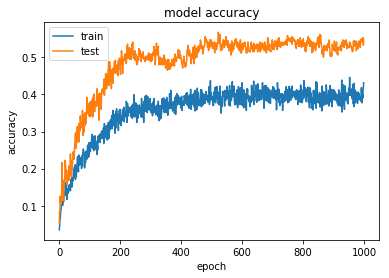

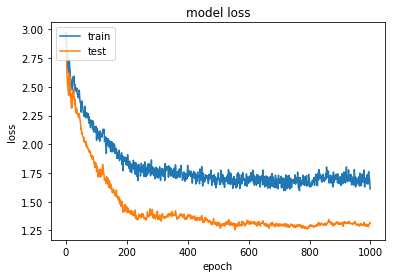

In [64]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()